# ミニプロジェクト 料理の画像を分類しよう

### 【実装内容】
* keras の学習済みモデル「**Xception**」をファインチューニング  
→ 全135層のうち、108層までは再学習せず、**109層以降**を学習用データで**再学習**させる
* 「ImageDataGenerator」で画像に人工的な変化を加え、学習用データを水増し  
→ 【加えた変化】**上下左右平行移動、左右反転**  
* コンパイル時の optimizer (最適化アルゴリズム)には「**Adam**」を使用
* バッチサイズ：32、エポック数：50

### 【結果】
* **Epoch 34/50 : early stopping**  
→ 10エポックの間で val_acc に改善がなかった為、エポック数 34回で学習を終了
* **loss: 0.0086 - acc: 0.9974 - val_loss: 0.1931 - val_acc: 0.9624**  
→ 学習データへの正答率　 ： <u>***99.74％***</u>  
　 テストデータへの正答率 ： <u>***96.24％***</u>

### データセット

|class|0  |1  |2  |3  |4  |
|---|---|---|---|---|---|
||![](figures/sushi.jpg)|![](figures/ramen.jpg)  |![](figures/pizza.jpg)  |![](figures/hamburger.jpg)  |![](figures/edamame.jpg)  |
||sushi  |ramen  |pizza  |hamburger  |edamame  |

|class|5  |6  |7  |8  |9  |
|---|---|---|---|---|---|
||![](figures/gyoza.jpg)|![](figures/bibimbap.jpg)  |![](figures/macarons.jpg)  |![](figures/oysters.jpg)  |![](figures/cake.jpg)  |
||gyoza  |bibimbap  |macarons  |oysters  |strawberry_shortcake  |


In [1]:
labels = [
    "寿司",
    "ラーメン",
    "ピザ",
    "ハンバーガ",
    "枝豆",
    "餃子",
    "ビビンバ",
    "マカロン",
    "牡蠣",
    "ストロベリーショートケーキ",
]

---

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input
from tensorflow.keras.optimizers import Adam

### 定数定義

In [3]:
path = "/root/userspace/contents/chapters/materials_1114/2_3_mini_project/"

# 分類数
num_classes = 10
# 画像の大きさ
img_width, img_height = 256, 256

# バッチサイズ
batch_size = 32
# エポック数
num_epoch = 50

### データ取得
※メモリ消費を抑えるため、テストデータの読込みは後述

In [4]:
X_train = np.load(path + "data/x_train.npy")
X_train = X_train / 255.

y_train = np.load(path + "data/y_train.npy")
y_train = to_categorical(y_train, num_classes=num_classes)

#### バリデーションデータの作成

In [5]:
# 学習データとバリデーションデータを作成
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state=0,
    stratify=y_train,
    test_size=0.2
)

### Kerasの学習済みモデルを再学習
参考：[Qiita Keras学習済みモデルをFine-tuningさせて精度比較](https://qiita.com/ha9kberry/items/daa2fc330c71485b2c27)

#### DataGenerator

In [6]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

#### Callback

In [7]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_acc',
    patience = 10,
    verbose = 1
)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

### モデル構築

In [8]:
# keras.Xception 呼出し
base_model = Xception(include_top=False, weights="imagenet", input_shape=None)

# 全結合層の新規構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# ネットワーク定義
model = Model(inputs=base_model.input, outputs=predictions)
print("{}層".format(len(model.layers)))

Instructions for updating:
Colocations handled automatically by placer.
135層


#### モデル可視化

In [9]:
!pip install graphviz
!pip install pydot
!dot -V

You are using pip version 8.1.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
dot - graphviz version 2.38.0 (20140413.2041)


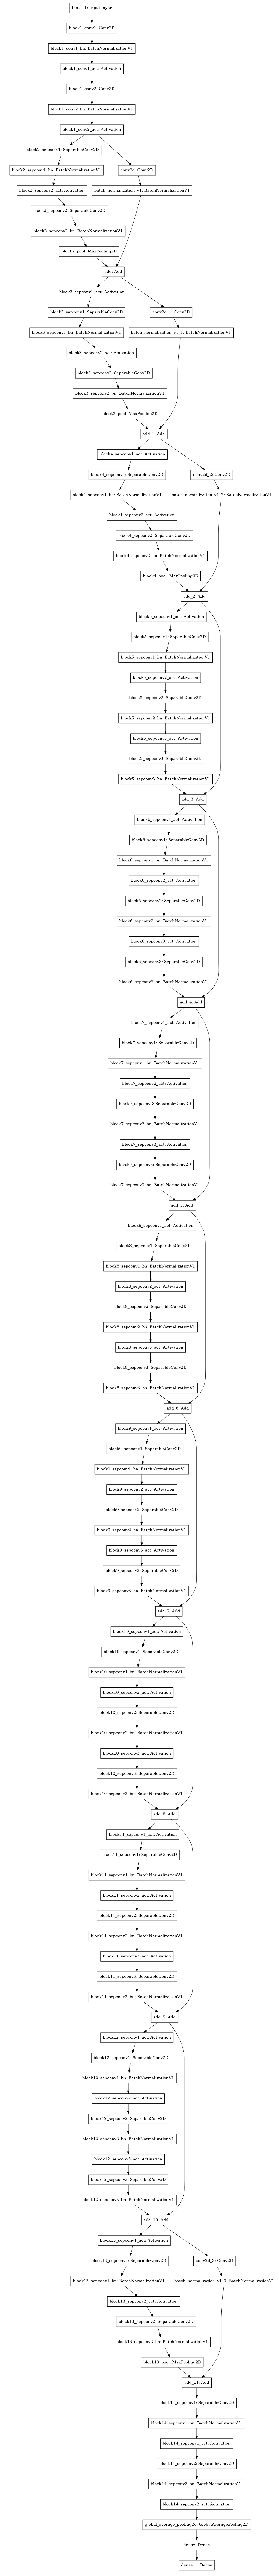

In [10]:
%matplotlib inline
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plot_model(model, to_file="model.png")

im = Image.open("model.png")
plt.figure(figsize=(32, 256))
plt.axis('off')
plt.imshow(np.array(im))
plt.show()

### 再学習方法を定義
109層以降（=block12以降）を再学習

In [11]:
# 108層までは再学習無し
for layer in model.layers[:108]:
    layer.trainable = False
    if layer.name.startswith("batch_normalization"):
        layer.trainable = True
    if layer.name.endswith("bn"):
        layer.trainable = True
    
# 109層以降は再学習させる
for layer in model.layers[108:]:
    layer.trainable = True
    
# compile
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

### 学習

In [12]:
result = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=(X_train.shape[0] // batch_size),
    epochs=num_epoch,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
213/213 [==============================] - 186s 875ms/step - loss: 0.5327 - acc: 0.8474 - val_loss: 0.4275 - val_acc: 0.9100
Epoch 2/50
213/213 [==============================] - 178s 835ms/step - loss: 0.2747 - acc: 0.9196 - val_loss: 0.2624 - val_acc: 0.9253
Epoch 3/50
213/213 [==============================] - 178s 837ms/step - loss: 0.2100 - acc: 0.9354 - val_loss: 0.2431 - val_acc: 0.9324
Epoch 4/50
213/213 [==============================] - 178s 837ms/step - loss: 0.1677 - acc: 0.9515 - val_loss: 0.3672 - val_acc: 0.9229
Epoch 5/50
213/213 [==============================] - 178s 837ms/step - loss: 0.1497 - acc: 0.9578 - val_loss: 0.2188 - val_acc: 0.9447
Epoch 6/50
213/213 [==============================] - 178s 837ms/step - loss: 0.1321 - acc: 0.9632 - val_loss: 0.2640 - val_acc: 0.9341
Epoch 7/50
213/213 [==============================] - 178s 836ms/step - loss: 0.0813 - acc: 0.9762 - val_loss: 0.2570 - val_acc: 0.9412


213/213 [==============================] - 178s 836ms/step - loss: 0.0086 - acc: 0.9974 - val_loss: 0.1931 - val_acc: 0.9624
Epoch 00034: early stopping


#### メモリ解放

In [13]:
del X_train, X_valid, y_train, y_valid

import gc
gc.collect()

196

### 予測

In [14]:
# テストデータ読込み
X_test = np.load(path + "data/x_test.npy")
X_test = X_test / 255.

# 予測
y_pred = model.predict(X_test)

In [15]:
# 最大値ラベルの取得 ⇒ 出力形式への変換
y_pred = np.argmax(y_pred, axis=1)
submission = pd.Series(y_pred, name='label')

# 予測値保存
submission.to_csv(path + "submission.csv", header=True, index_label="id")

#### 簡易チェック（冒頭50件）

'マカロン'

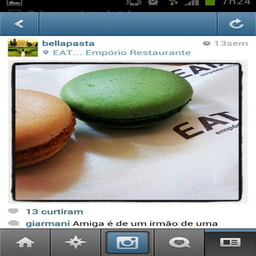

'餃子'

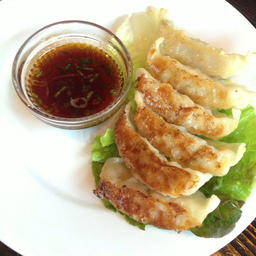

'餃子'

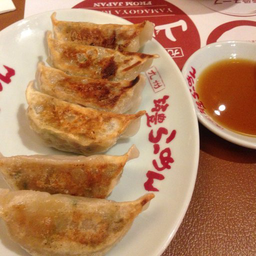

'ハンバーガ'

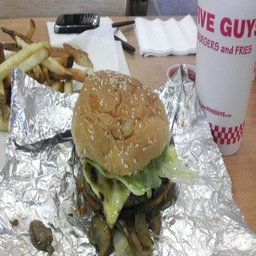

'ピザ'

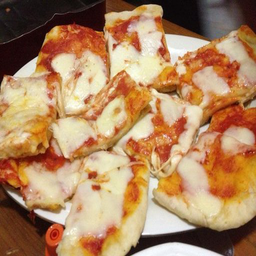

'ストロベリーショートケーキ'

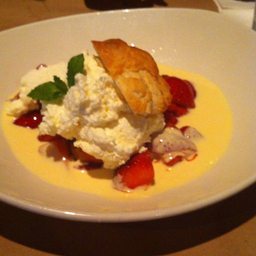

'ラーメン'

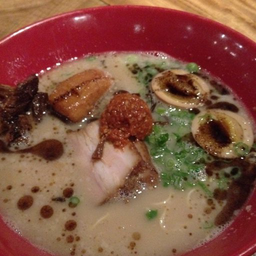

'ストロベリーショートケーキ'

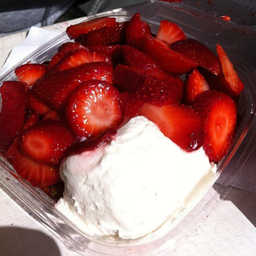

'餃子'

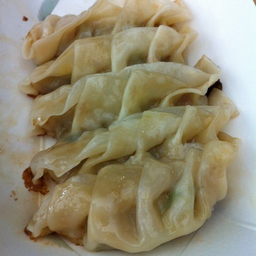

'寿司'

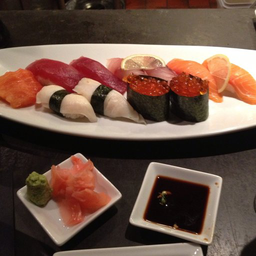

'寿司'

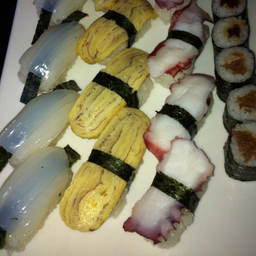

'ストロベリーショートケーキ'

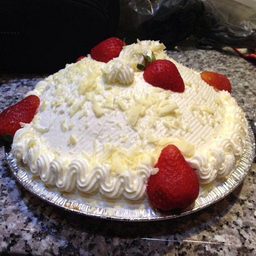

'枝豆'

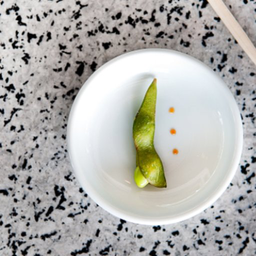

'餃子'

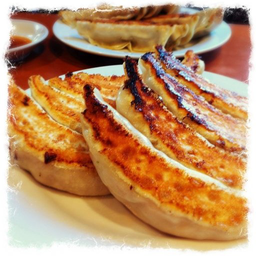

'マカロン'

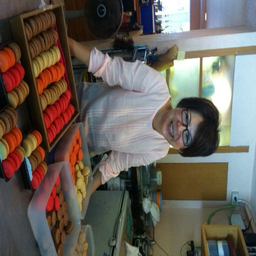

'ビビンバ'

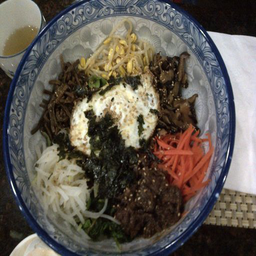

'マカロン'

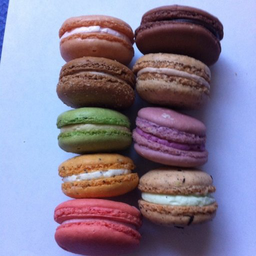

'餃子'

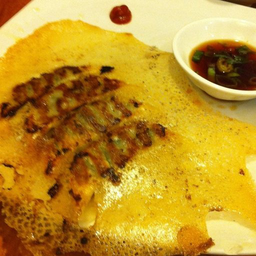

'ハンバーガ'

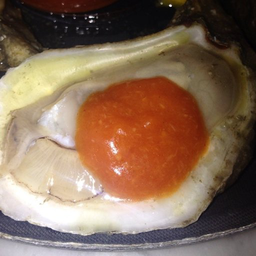

'ビビンバ'

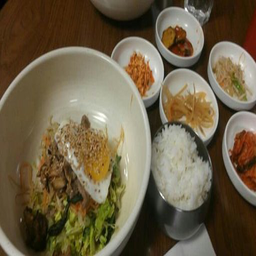

'枝豆'

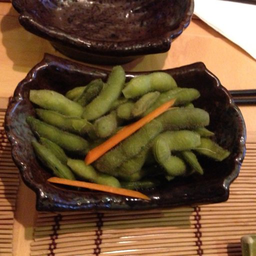

'枝豆'

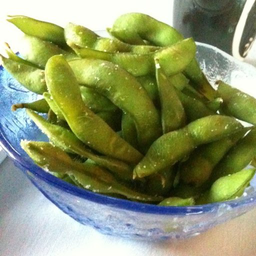

'ストロベリーショートケーキ'

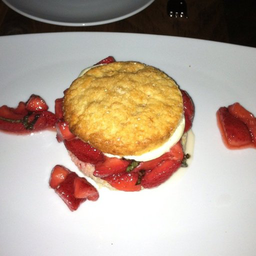

'牡蠣'

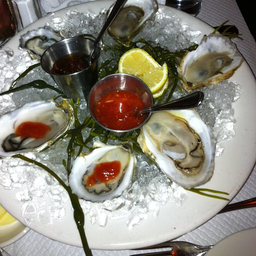

'ラーメン'

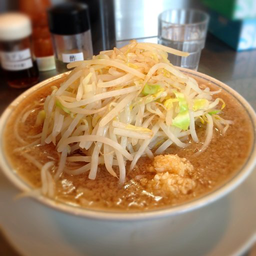

'枝豆'

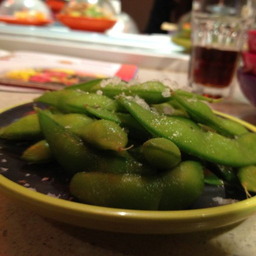

'ビビンバ'

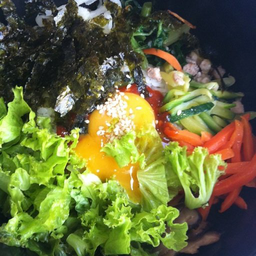

'餃子'

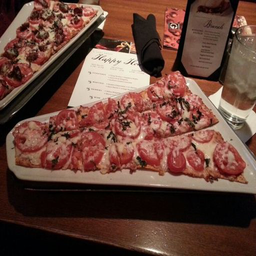

'寿司'

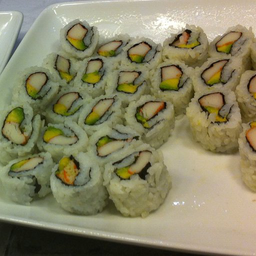

'ラーメン'

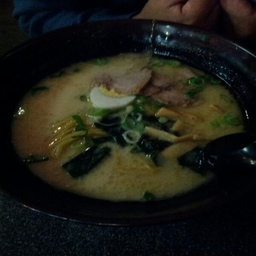

'ビビンバ'

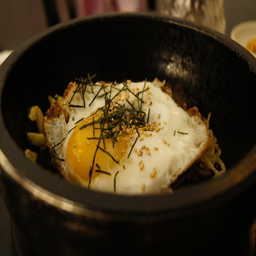

'寿司'

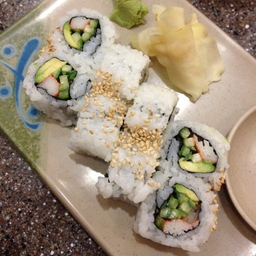

'ピザ'

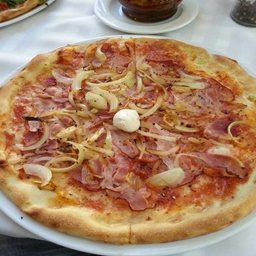

'マカロン'

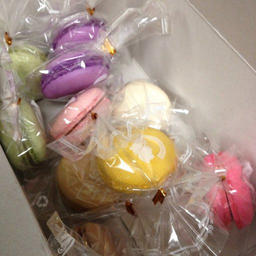

'ハンバーガ'

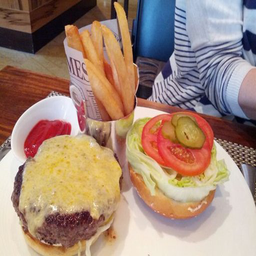

'ラーメン'

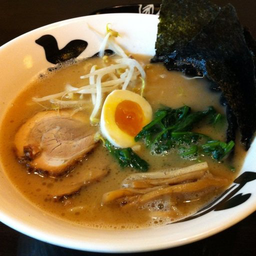

'餃子'

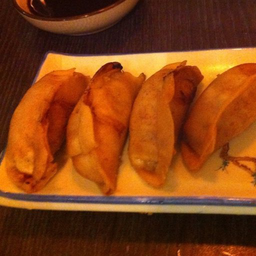

'寿司'

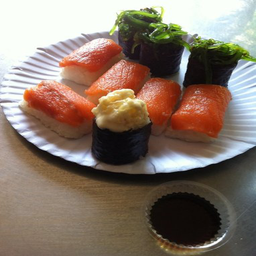

'ハンバーガ'

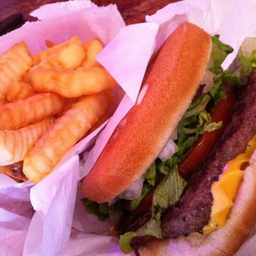

'餃子'

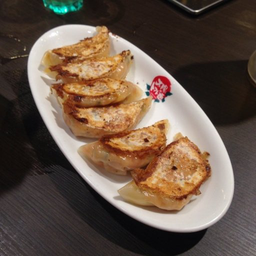

'ラーメン'

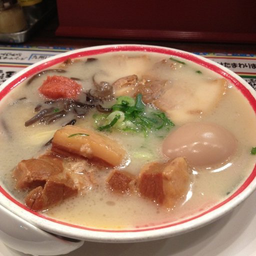

'ビビンバ'

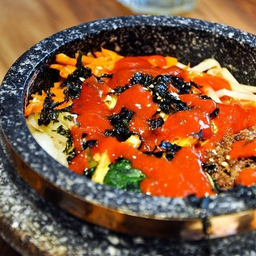

'牡蠣'

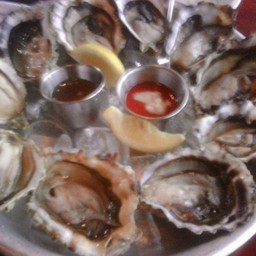

'ピザ'

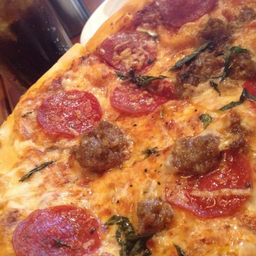

'枝豆'

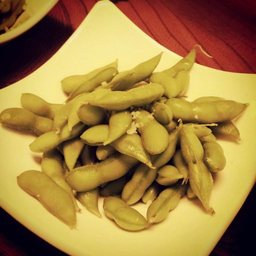

'牡蠣'

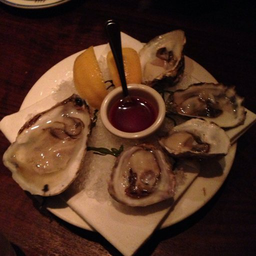

'ピザ'

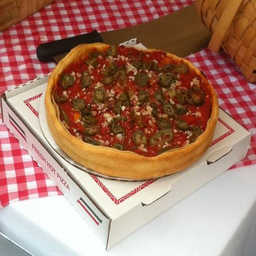

'牡蠣'

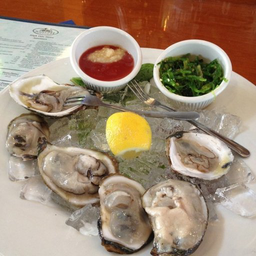

'ハンバーガ'

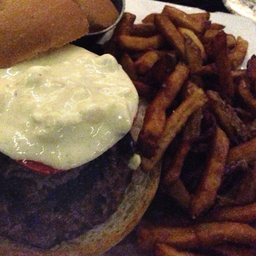

'寿司'

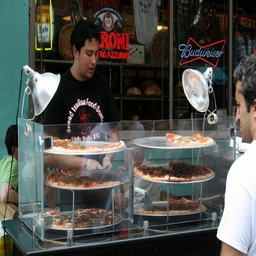

In [16]:
import numpy as np
import pandas as pd
from PIL import Image

path = "/root/userspace/contents/chapters/materials_1114/2_3_mini_project/"
X_test = np.load(path + "data/x_test.npy")
y_pred = pd.read_csv(path + "submission.csv", index_col=0)

for idx in range(50):
    display(labels[y_pred.loc[idx, "label"]])
    display(Image.fromarray(np.uint8(X_test[idx])))